# 📊 Exploratory Data Analysis - Madagascar Vanilla Prices

Ce notebook analyse les données de prix de la vanille malgache pour:
1. Comprendre les tendances et patterns
2. Identifier la saisonnalité
3. Détecter les anomalies
4. Préparer les données pour le modeling

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuration plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Paths
DATA_PATH = Path('../data/processed')
OUTPUT_PATH = Path('../outputs/figures')

print("✅ Configuration loaded")

✅ Configuration loaded


In [2]:
# Charger les données
df = pd.read_csv(DATA_PATH / 'vanilla_prices.csv', parse_dates=['date'])
df = df.set_index('date')

print(f"📊 Dataset shape: {df.shape}")
print(f"📅 Période: {df.index.min().date()} → {df.index.max().date()}")
print(f"\n📋 Colonnes: {list(df.columns)}")

📊 Dataset shape: (168, 25)
📅 Période: 2010-01-01 → 2023-12-01

📋 Colonnes: ['price_usd_kg', 'year', 'month', 'quarter', 'month_sin', 'month_cos', 'harvest_season', 'cyclone_season', 'export_season', 'price_lag1', 'price_lag2', 'price_lag3', 'price_lag6', 'price_lag12', 'price_ma3', 'price_std3', 'price_ma6', 'price_std6', 'price_ma12', 'price_std12', 'price_pct_change', 'price_pct_change_3m', 'price_pct_change_12m', 'price_vs_ma12', 'volatility']


## 1. Vue d'ensemble des données

In [3]:
# Statistiques descriptives
print("📈 Statistiques des prix (USD/kg):")
print("="*40)
stats = df['price_usd_kg'].describe()
print(f"Moyenne: ${stats['mean']:.2f}")
print(f"Médiane: ${df['price_usd_kg'].median():.2f}")
print(f"Min: ${stats['min']:.2f}")
print(f"Max: ${stats['max']:.2f}")
print(f"Écart-type: ${stats['std']:.2f}")
print(f"\nCoef. de variation: {(stats['std']/stats['mean']*100):.1f}%")

📈 Statistiques des prix (USD/kg):
Moyenne: $193.38
Médiane: $203.81
Min: $18.04
Max: $466.48
Écart-type: $152.07

Coef. de variation: 78.6%


In [4]:
# Données manquantes
missing = df.isnull().sum()
if missing.sum() > 0:
    print("⚠️ Valeurs manquantes:")
    print(missing[missing > 0])
else:
    print("✅ Aucune valeur manquante dans la variable cible")

⚠️ Valeurs manquantes:
price_lag1               1
price_lag2               2
price_lag3               3
price_lag6               6
price_lag12             12
price_ma3                2
price_std3               2
price_ma6                5
price_std6               5
price_ma12              11
price_std12             11
price_pct_change         1
price_pct_change_3m      3
price_pct_change_12m    12
price_vs_ma12           11
volatility               5
dtype: int64


## 2. Évolution temporelle des prix

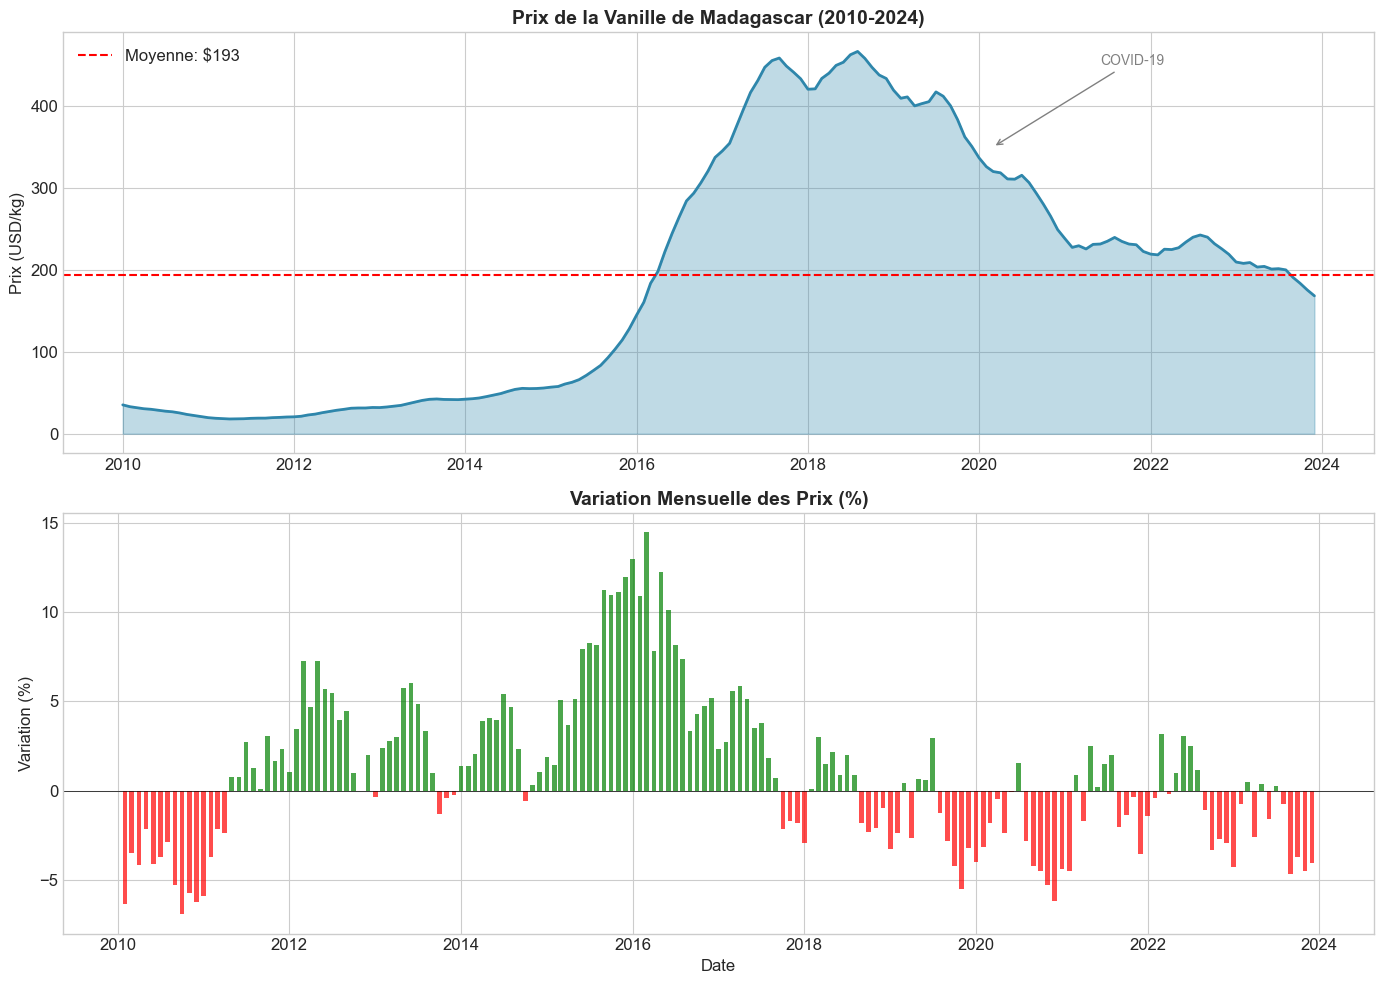

✅ Figure sauvegardée: outputs/figures/price_evolution.png


In [5]:
# Plot de la série temporelle principale
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Prix bruts
ax1 = axes[0]
ax1.plot(df.index, df['price_usd_kg'], linewidth=2, color='#2E86AB')
ax1.fill_between(df.index, df['price_usd_kg'], alpha=0.3, color='#2E86AB')
ax1.set_title('Prix de la Vanille de Madagascar (2010-2024)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Prix (USD/kg)')
ax1.axhline(y=df['price_usd_kg'].mean(), color='red', linestyle='--', label=f'Moyenne: ${df["price_usd_kg"].mean():.0f}')

# Annotations des événements clés
ax1.annotate('Pic historique\n(spéculation)', 
             xy=(pd.Timestamp('2018-01-01'), 600), 
             xytext=(pd.Timestamp('2015-01-01'), 550),
             arrowprops=dict(arrowstyle='->', color='red'),
             fontsize=10, color='red')

ax1.annotate('COVID-19', 
             xy=(pd.Timestamp('2020-03-01'), 350), 
             xytext=(pd.Timestamp('2021-06-01'), 450),
             arrowprops=dict(arrowstyle='->', color='gray'),
             fontsize=10, color='gray')

ax1.legend(loc='upper left')

# Variation mensuelle en %
ax2 = axes[1]
colors = ['green' if x > 0 else 'red' for x in df['price_pct_change'].fillna(0)]
ax2.bar(df.index, df['price_pct_change']*100, color=colors, alpha=0.7, width=20)
ax2.axhline(y=0, color='black', linewidth=0.5)
ax2.set_title('Variation Mensuelle des Prix (%)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Variation (%)')
ax2.set_xlabel('Date')

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'price_evolution.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Figure sauvegardée: outputs/figures/price_evolution.png")

## 3. Analyse de la saisonnalité

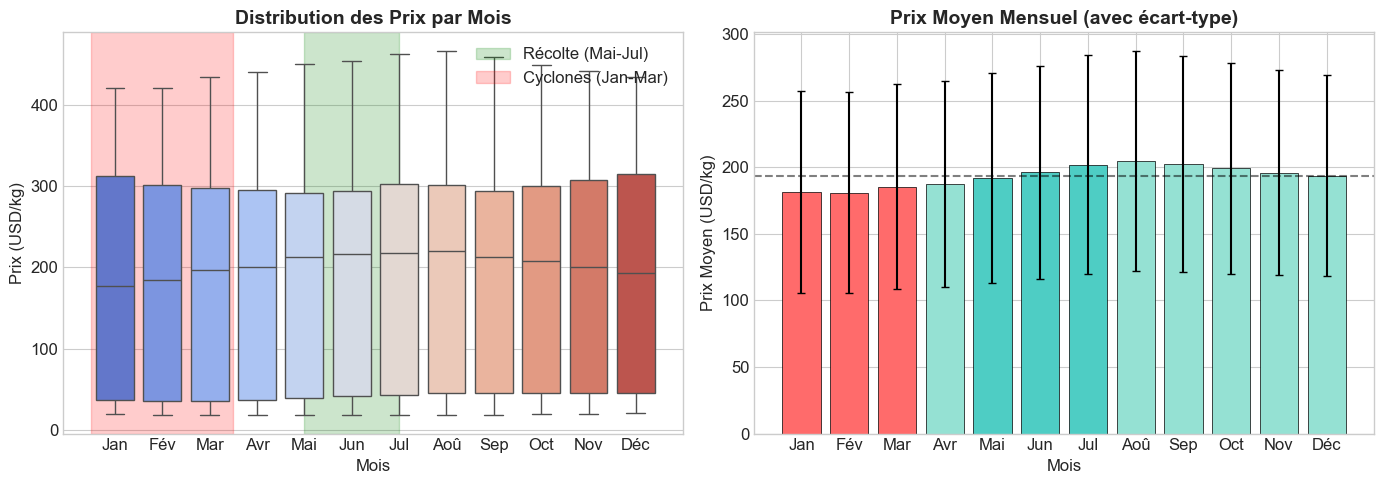

In [6]:
# Prix moyen par mois
monthly_avg = df.groupby('month')['price_usd_kg'].agg(['mean', 'std'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot par mois
ax1 = axes[0]
month_names = ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jun', 'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc']
df_plot = df.copy()
df_plot['month_name'] = df_plot['month'].map(lambda x: month_names[x-1])

sns.boxplot(data=df_plot, x='month', y='price_usd_kg', ax=ax1, palette='coolwarm')
ax1.set_xticklabels(month_names)
ax1.set_title('Distribution des Prix par Mois', fontsize=14, fontweight='bold')
ax1.set_xlabel('Mois')
ax1.set_ylabel('Prix (USD/kg)')

# Ajouter zones saisonnières
ax1.axvspan(4, 6, alpha=0.2, color='green', label='Récolte (Mai-Jul)')
ax1.axvspan(-0.5, 2.5, alpha=0.2, color='red', label='Cyclones (Jan-Mar)')
ax1.legend(loc='upper right')

# Bar chart moyenne par mois
ax2 = axes[1]
colors = ['#FF6B6B' if i in [0, 1, 2] else '#4ECDC4' if i in [4, 5, 6] else '#95E1D3' for i in range(12)]
bars = ax2.bar(month_names, monthly_avg['mean'], yerr=monthly_avg['std']/2, 
               capsize=3, color=colors, edgecolor='black', linewidth=0.5)
ax2.set_title('Prix Moyen Mensuel (avec écart-type)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Mois')
ax2.set_ylabel('Prix Moyen (USD/kg)')
ax2.axhline(y=df['price_usd_kg'].mean(), color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'seasonality_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

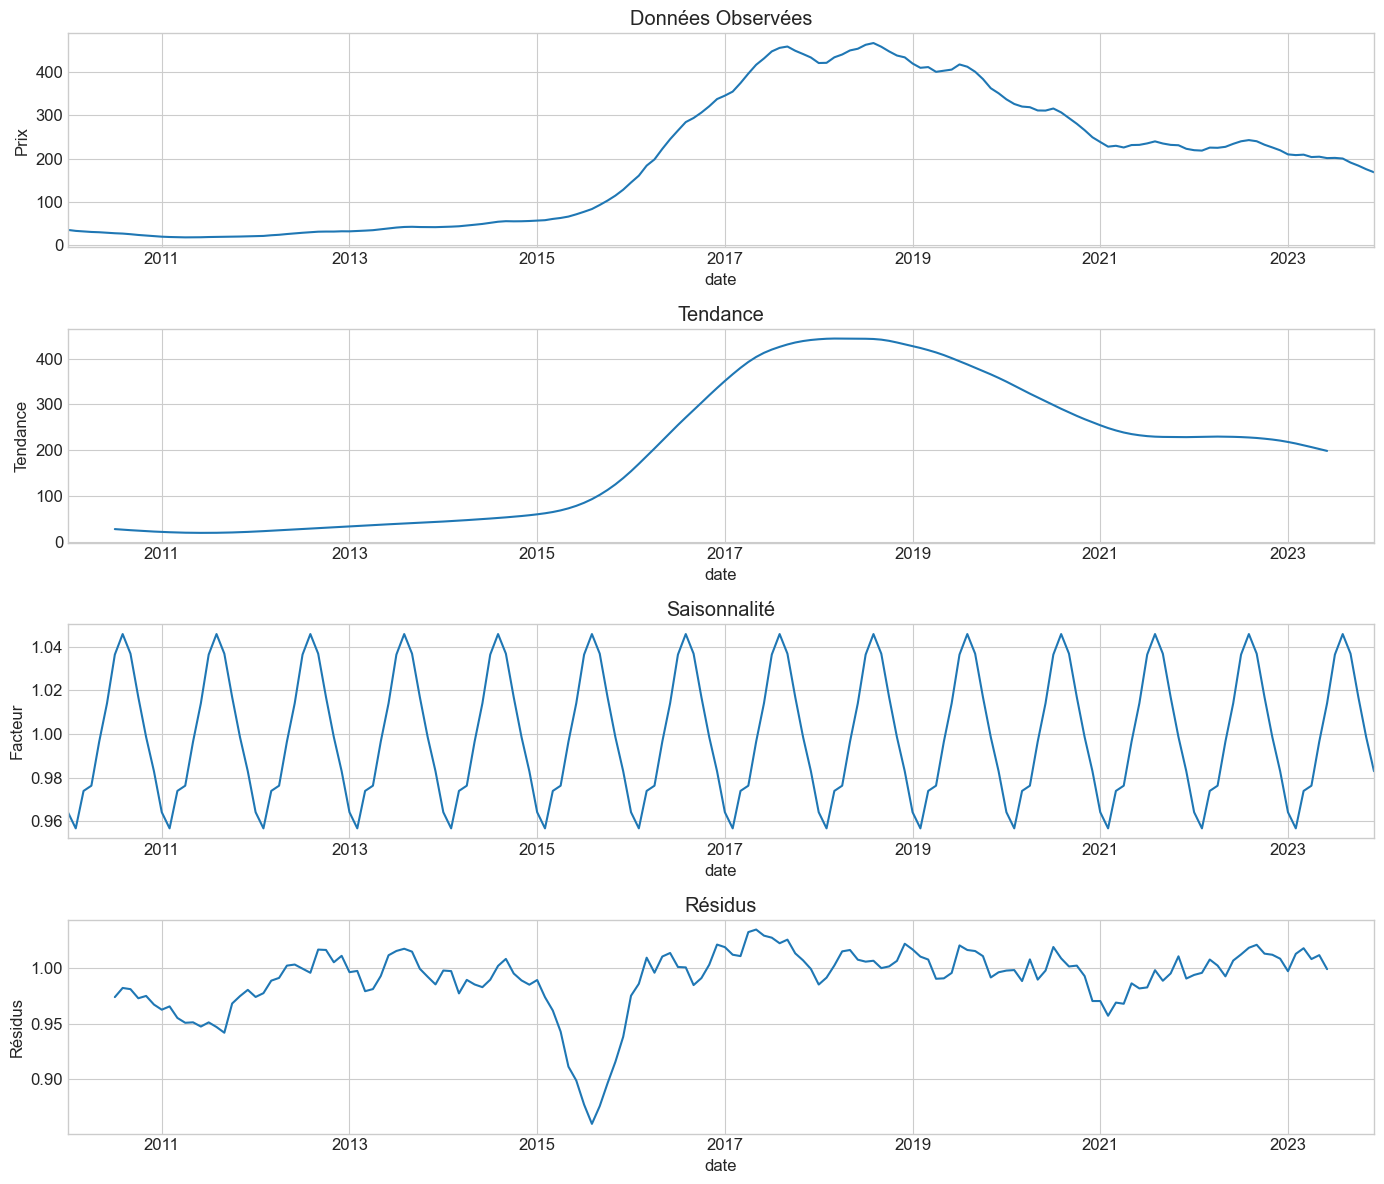

In [7]:
# Décomposition de la série temporelle
from statsmodels.tsa.seasonal import seasonal_decompose

# Décomposition
decomposition = seasonal_decompose(df['price_usd_kg'], model='multiplicative', period=12)

fig, axes = plt.subplots(4, 1, figsize=(14, 12))

decomposition.observed.plot(ax=axes[0], title='Données Observées')
axes[0].set_ylabel('Prix')

decomposition.trend.plot(ax=axes[1], title='Tendance')
axes[1].set_ylabel('Tendance')

decomposition.seasonal.plot(ax=axes[2], title='Saisonnalité')
axes[2].set_ylabel('Facteur')

decomposition.resid.plot(ax=axes[3], title='Résidus')
axes[3].set_ylabel('Résidus')

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'time_series_decomposition.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Analyse par année

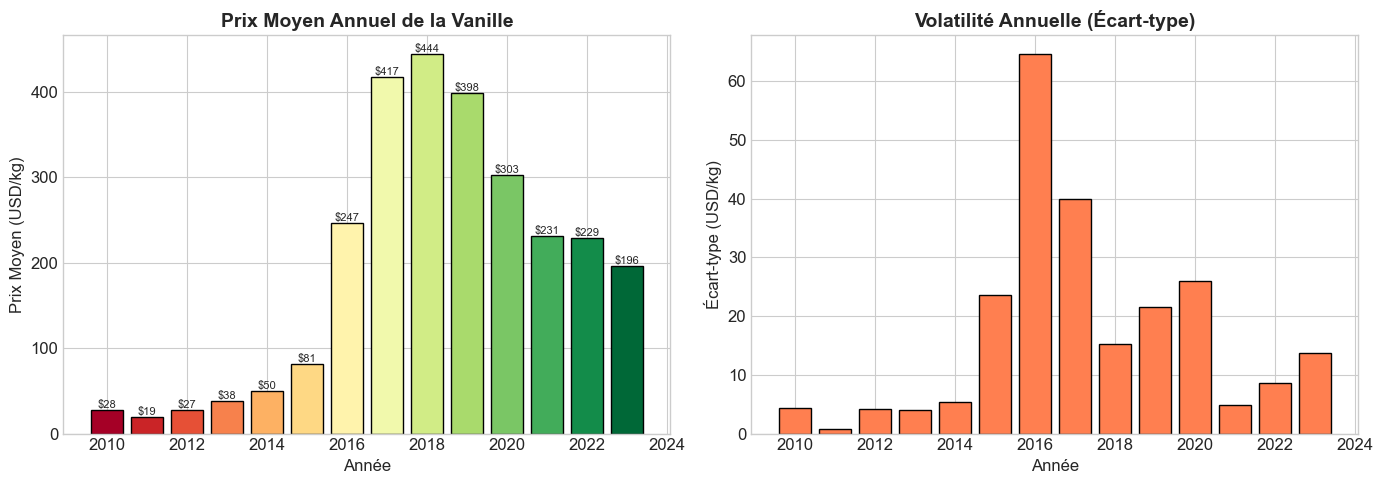

In [8]:
# Statistiques par année
yearly_stats = df.groupby('year')['price_usd_kg'].agg(['mean', 'min', 'max', 'std'])
yearly_stats['range'] = yearly_stats['max'] - yearly_stats['min']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Prix moyen par année
ax1 = axes[0]
colors = plt.cm.RdYlGn(np.linspace(0, 1, len(yearly_stats)))
bars = ax1.bar(yearly_stats.index, yearly_stats['mean'], color=colors, edgecolor='black')
ax1.set_title('Prix Moyen Annuel de la Vanille', fontsize=14, fontweight='bold')
ax1.set_xlabel('Année')
ax1.set_ylabel('Prix Moyen (USD/kg)')

# Annoter les valeurs
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'${height:.0f}', ha='center', va='bottom', fontsize=8)

# Volatilité par année
ax2 = axes[1]
ax2.bar(yearly_stats.index, yearly_stats['std'], color='coral', edgecolor='black')
ax2.set_title('Volatilité Annuelle (Écart-type)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Année')
ax2.set_ylabel('Écart-type (USD/kg)')

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'yearly_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Analyse des corrélations

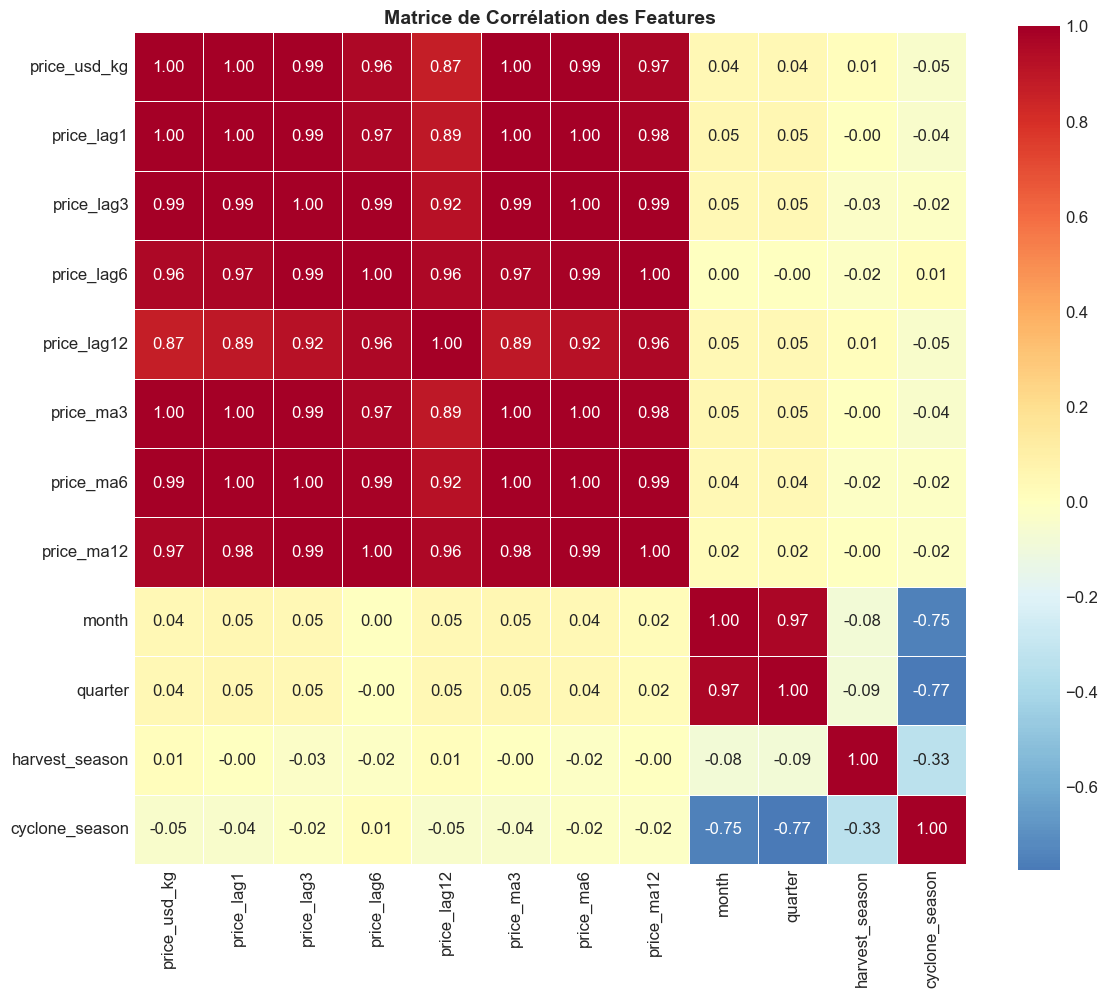

In [9]:
# Corrélation entre features
features_to_analyze = ['price_usd_kg', 'price_lag1', 'price_lag3', 'price_lag6', 'price_lag12',
                       'price_ma3', 'price_ma6', 'price_ma12', 'month', 'quarter',
                       'harvest_season', 'cyclone_season']

df_corr = df[features_to_analyze].dropna()
correlation_matrix = df_corr.corr()

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='RdYlBu_r', 
            center=0, ax=ax, square=True, linewidths=0.5)
ax.set_title('Matrice de Corrélation des Features', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

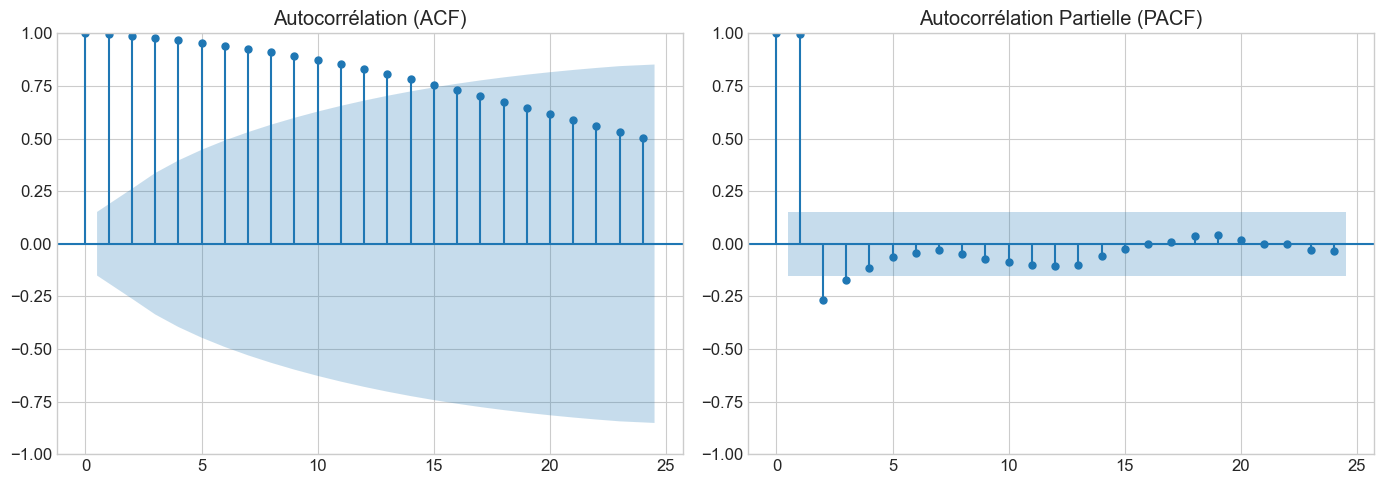

💡 L'ACF décroît lentement → série non-stationnaire, tendance présente
💡 La PACF a un pic significatif au lag 1 → modèle AR(1) possible


In [10]:
# Autocorrélation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(df['price_usd_kg'].dropna(), lags=24, ax=axes[0], title='Autocorrélation (ACF)')
plot_pacf(df['price_usd_kg'].dropna(), lags=24, ax=axes[1], title='Autocorrélation Partielle (PACF)')

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'autocorrelation.png', dpi=150, bbox_inches='tight')
plt.show()

print("💡 L'ACF décroît lentement → série non-stationnaire, tendance présente")
print("💡 La PACF a un pic significatif au lag 1 → modèle AR(1) possible")

## 6. Distribution des prix

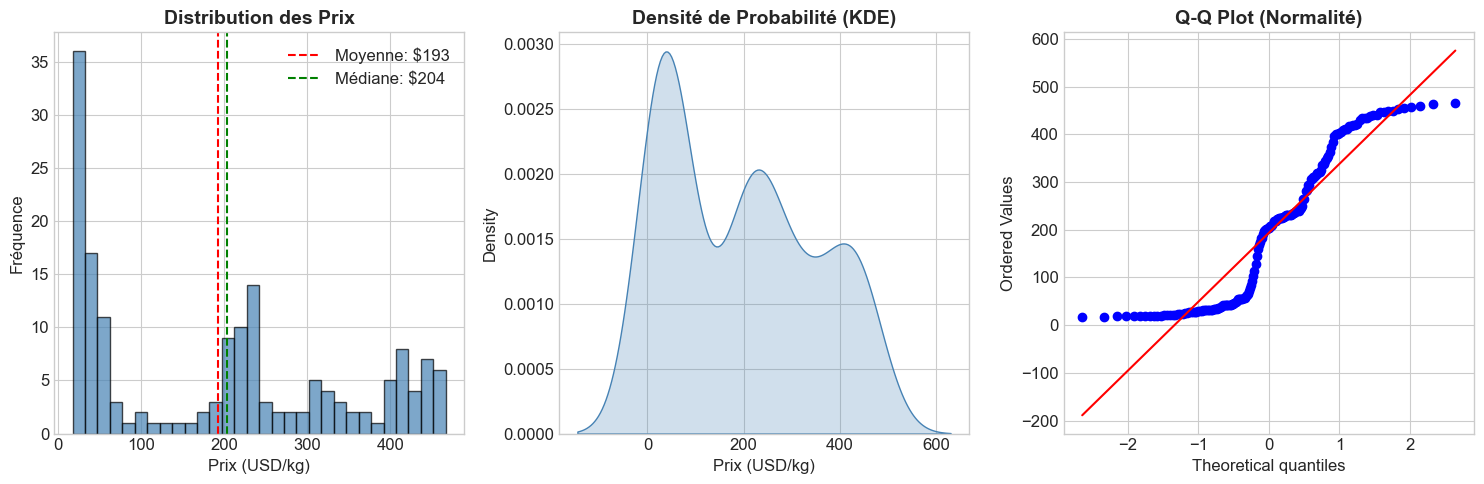


📊 Test de Shapiro-Wilk: p-value = 0.0017
⚠️ La distribution n'est PAS normale (p < 0.05)


In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Histogramme
ax1 = axes[0]
ax1.hist(df['price_usd_kg'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(df['price_usd_kg'].mean(), color='red', linestyle='--', label=f'Moyenne: ${df["price_usd_kg"].mean():.0f}')
ax1.axvline(df['price_usd_kg'].median(), color='green', linestyle='--', label=f'Médiane: ${df["price_usd_kg"].median():.0f}')
ax1.set_title('Distribution des Prix', fontsize=14, fontweight='bold')
ax1.set_xlabel('Prix (USD/kg)')
ax1.set_ylabel('Fréquence')
ax1.legend()

# KDE plot
ax2 = axes[1]
sns.kdeplot(df['price_usd_kg'], ax=ax2, fill=True, color='steelblue')
ax2.set_title('Densité de Probabilité (KDE)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Prix (USD/kg)')

# Q-Q plot
from scipy import stats
ax3 = axes[2]
stats.probplot(df['price_usd_kg'], dist='norm', plot=ax3)
ax3.set_title('Q-Q Plot (Normalité)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'price_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Test de normalité
stat, p_value = stats.shapiro(df['price_usd_kg'][:50])  # Shapiro limité à 50 obs
print(f"\n📊 Test de Shapiro-Wilk: p-value = {p_value:.4f}")
if p_value < 0.05:
    print("⚠️ La distribution n'est PAS normale (p < 0.05)")
else:
    print("✅ La distribution peut être considérée normale (p >= 0.05)")

## 7. Stationnarité

In [12]:
from statsmodels.tsa.stattools import adfuller, kpss

# Test ADF
def adf_test(series, name=''):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f"\n📊 Test ADF - {name}")
    print(f"   Statistique: {result[0]:.4f}")
    print(f"   P-value: {result[1]:.4f}")
    print(f"   Lags utilisés: {result[2]}")
    if result[1] <= 0.05:
        print("   ✅ Série STATIONNAIRE (p <= 0.05)")
    else:
        print("   ⚠️ Série NON-STATIONNAIRE (p > 0.05)")
    return result[1]

# Test sur série originale
adf_test(df['price_usd_kg'], 'Prix originaux')

# Test sur différence première
df['price_diff'] = df['price_usd_kg'].diff()
adf_test(df['price_diff'], 'Différence première')

# Test sur log-différence
df['price_log_diff'] = np.log(df['price_usd_kg']).diff()
adf_test(df['price_log_diff'], 'Log-différence')


📊 Test ADF - Prix originaux
   Statistique: -1.8722
   P-value: 0.3453
   Lags utilisés: 14
   ⚠️ Série NON-STATIONNAIRE (p > 0.05)

📊 Test ADF - Différence première
   Statistique: -2.0961
   P-value: 0.2461
   Lags utilisés: 13
   ⚠️ Série NON-STATIONNAIRE (p > 0.05)

📊 Test ADF - Log-différence
   Statistique: -2.5522
   P-value: 0.1033
   Lags utilisés: 13
   ⚠️ Série NON-STATIONNAIRE (p > 0.05)


np.float64(0.10328068041663152)

## 8. Détection des outliers

In [13]:
# Détection avec IQR
Q1 = df['price_usd_kg'].quantile(0.25)
Q3 = df['price_usd_kg'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['price_usd_kg'] < lower_bound) | (df['price_usd_kg'] > upper_bound)]

print(f"📊 Détection d'outliers (méthode IQR):")
print(f"   Q1: ${Q1:.2f}")
print(f"   Q3: ${Q3:.2f}")
print(f"   IQR: ${IQR:.2f}")
print(f"   Bornes: [${lower_bound:.2f}, ${upper_bound:.2f}]")
print(f"\n   Nombre d'outliers: {len(outliers)}")

if len(outliers) > 0:
    print("\n   Dates des outliers:")
    for idx, row in outliers.iterrows():
        print(f"   - {idx.date()}: ${row['price_usd_kg']:.2f}")

📊 Détection d'outliers (méthode IQR):
   Q1: $40.22
   Q3: $316.17
   IQR: $275.95
   Bornes: [$-373.70, $730.09]

   Nombre d'outliers: 0


## 9. Résumé de l'EDA

### 🔍 Principales observations:

1. **Tendance**: Forte hausse 2014-2018, puis baisse progressive
2. **Saisonnalité**: Légère hausse post-récolte (juin-août)
3. **Volatilité**: Très élevée (coefficient de variation > 50%)
4. **Non-stationnarité**: Nécessite différenciation pour modélisation
5. **Autocorrélation**: Forte corrélation avec lags récents (AR)

### 📋 Recommandations pour le modeling:

- Utiliser la **différenciation** pour stationnariser
- Inclure **lag features** (lag1, lag3, lag12)
- Ajouter **indicateurs saisonniers**
- Considérer **transformations log** pour stabiliser variance
- Tester modèles: **SARIMA**, **Prophet**, **XGBoost**

In [14]:
# Sauvegarder le résumé
summary = {
    'observations': len(df),
    'start_date': df.index.min().strftime('%Y-%m-%d'),
    'end_date': df.index.max().strftime('%Y-%m-%d'),
    'mean_price': df['price_usd_kg'].mean(),
    'median_price': df['price_usd_kg'].median(),
    'min_price': df['price_usd_kg'].min(),
    'max_price': df['price_usd_kg'].max(),
    'std_price': df['price_usd_kg'].std(),
    'cv_percent': (df['price_usd_kg'].std() / df['price_usd_kg'].mean() * 100)
}

print("\n" + "="*50)
print("📋 RÉSUMÉ DE L'ANALYSE EXPLORATOIRE")
print("="*50)
for key, value in summary.items():
    if isinstance(value, float):
        print(f"{key}: {value:.2f}")
    else:
        print(f"{key}: {value}")


📋 RÉSUMÉ DE L'ANALYSE EXPLORATOIRE
observations: 168
start_date: 2010-01-01
end_date: 2023-12-01
mean_price: 193.38
median_price: 203.81
min_price: 18.04
max_price: 466.48
std_price: 152.07
cv_percent: 78.64
